In [1]:
import numpy as np

import matplotlib.pyplot as plt
# 设置 Matplotlib 使用支持中文的字体
# plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 用户
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS 用户
# plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # Linux 用户
# 解决负号 '-' 显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

from pyswarm import pso

import CDPD_control_dual as model_sim
import CDPD_simplify_half_compare as model_opt
import mytoolkit as tool
import CDPD_control_dual_parameters as param
import PIDcontroller as PID
import optimization as opt

SimulationConfig(t0=0, tf=100, fps=100, rtol=1e-06, atol=1e-06)
100.0
[5.00e+01 2.00e+01 2.00e+01 2.00e+01 4.00e+01 1.00e+01 0.00e+00 1.00e+05
 1.00e+05 3.00e+04 3.00e+05 3.00e+04 9.81e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
[ 0.         17.32050808 -1.57079633 -1.57079633  0.52359878  1.57079633
  1.57079633  0.          0.          0.          0.          0.        ]


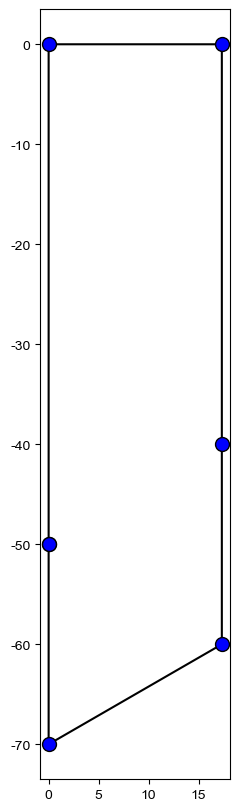

In [31]:
startSimulation =param.CDPDInitialParam(structure_paras=np.array([50, 20, 20,20, 40, 10,0]),weight_paras=np.array([100e3,100e3,30e3,300e3,30e3,9.81]))

config = model_opt.SimulationConfig(0,100,100,1e-6,1e-6)

desired_settling_time = startSimulation.getDesired_settling_time()
print(config)
print(desired_settling_time)

p_vals_CDPD = startSimulation.getParameters_CDPD()
x0_CDPD = startSimulation.getInitialStates_CDPD()
print(p_vals_CDPD)
print(x0_CDPD)
model_opt.CDPD(p_vals_CDPD).setup_figure_plot(x0_CDPD,p_vals_CDPD)


这个系统的优化和哪些东西有关，控制力的大小，ITAE最小的优化目标和目标时间有关，需要计算ITAE本身的最小值是多少

In [32]:
distance = (0.0,0.0)
vp = 1 # m/s
vptheta1 = vp /(p_vals_CDPD[0]+p_vals_CDPD[1])
vptheta2 = vp /(p_vals_CDPD[3]+p_vals_CDPD[4])
x0_CDPD[7] =0
x0_CDPD[8] =0
x0_CDPD[9] =vptheta1*p_vals_CDPD[0]
x0_CDPD[10] =vptheta1*p_vals_CDPD[1]
x0_CDPD[11] =vptheta2*p_vals_CDPD[4]

print(x0_CDPD[7:])
target = x0_CDPD[:2]+distance
# p_vals_CPD[11:13] = [-1000,-1000]

pid = np.array([ 4.89097990e+04,  5.89411432e+04,  0, 0,
  2.39978495e+05,  2.39920085e+05])
# [ 5.70093133e+04  4.09627250e+04  5.13680821e+00 -3.04922706e+00
#   2.55430320e+05  2.59543164e+05] 21.305192436383567
# 最终最优 PID 参数: [ 6.35629110e+04 -6.21511977e-01  3.50260333e+05]
# 最终目标函数最小值: 590.8700995133054
# 初始 PID 参数取值范围：Kp, Ki, Kd
lb_initial = np.array([0,0,0,0,0,0])
ub_initial = np.array([1e7,1e7,1e3,1e3,1e8,1e8])
# lb_initial2 = np.array([lb_initial[0],lb_initial[2]])
# ub_initial2 = np.array([ub_initial[0],ub_initial[2]])

time_interval = 0.1
pid_controller = PID.PIDControl_seperate(target,pid,time_interval,control_max=1e5)
systemfunc = model_opt.CDPDC_opt(p_vals_CDPD,x0_CDPD,control_strategy=pid_controller,config=config)
systemsim = model_sim.CDPDC_opt(p_vals_CDPD,x0_CDPD,control_strategy=pid_controller,config=config)
print(lb_initial)
print(ub_initial)


[0.         0.         0.71428571 0.28571429 0.66666667]
[0 0 0 0 0 0]
[1.e+07 1.e+07 1.e+03 1.e+03 1.e+08 1.e+08]


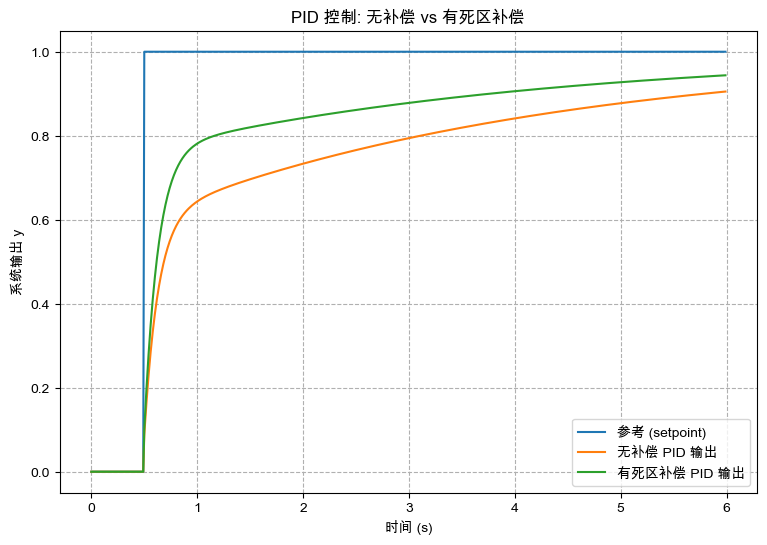

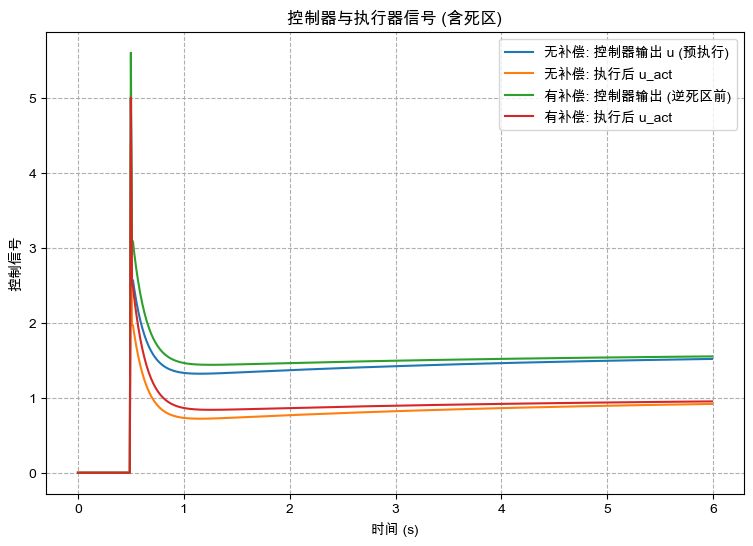

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # =========================
# # 仿真参数
# # =========================
# dt = 0.01     # 仿真步长
# T = 6.0       # 仿真总时间
# t = np.arange(0, T, dt)

# # 被控对象：一阶惯性环节 G(s) = 1 / (tau s + 1)
# tau = 0.5
# def plant_step(x, u):
#     dx = (-x + u) / tau
#     return x + dx * dt

# # =========================
# # 执行器模型：带死区
# # =========================
# dead_zone = 0.6  # 死区阈值

# def dead_zone_actuator(u):
#     """死区非线性"""
#     if u > dead_zone:
#         return u - dead_zone
#     elif u < -dead_zone:
#         return u + dead_zone
#     else:
#         return 0.0

# def dead_zone_inverse(u):
#     """逆死区补偿（最简单的伪逆）"""
#     if u > 0:
#         return u + dead_zone
#     elif u < 0:
#         return u - dead_zone
#     else:
#         return 0.0

# # =========================
# # PID 控制器参数
# # =========================
# Kp = 3.0
# Ki = 1.0
# Kd = 0.02

# # 参考输入 (阶跃)
# r = np.ones_like(t) * 1.0
# r[t < 0.5] = 0.0

# # =========================
# # 仿真容器
# # =========================
# y_nom = np.zeros_like(t)   # 无补偿输出
# y_comp = np.zeros_like(t)  # 有补偿输出
# u_nom = np.zeros_like(t)   # 无补偿：控制器输出
# u_nom_act = np.zeros_like(t)  # 无补偿：执行后信号
# u_comp = np.zeros_like(t)  # 有补偿：控制器输出（逆死区前）
# u_comp_act = np.zeros_like(t) # 有补偿：执行后信号

# # =========================
# # 无补偿 PID 仿真
# # =========================
# x = 0.0
# integral = 0.0
# prev_err = 0.0

# for i in range(len(t)):
#     err = r[i] - x
#     derivative = (err - prev_err) / dt
#     u = Kp * err + Ki * integral + Kd * derivative
#     u_act = dead_zone_actuator(u)
#     # anti-windup：仅在有实际动作或动作有利于减小误差时积分
#     if (u_act * err) > 0 or abs(u_act) > 0:
#         integral += err * dt
#     u_nom[i] = u
#     u_nom_act[i] = u_act
#     x = plant_step(x, u_act)
#     y_nom[i] = x
#     prev_err = err

# # =========================
# # 有死区补偿 PID 仿真
# # =========================
# x = 0.0
# integral = 0.0
# prev_err = 0.0

# for i in range(len(t)):
#     err = r[i] - x
#     derivative = (err - prev_err) / dt
#     u_desired = Kp * err + Ki * integral + Kd * derivative
#     # 在进入执行器前做逆死区补偿
#     u_pre = dead_zone_inverse(u_desired)
#     u_act = dead_zone_actuator(u_pre)
#     if (u_act * err) > 0 or abs(u_act) > 0:
#         integral += err * dt
#     u_comp[i] = u_pre
#     u_comp_act[i] = u_act
#     x = plant_step(x, u_act)
#     y_comp[i] = x
#     prev_err = err

# # =========================
# # 绘图
# # =========================
# plt.figure(figsize=(9, 6))
# plt.plot(t, r, label="参考 (setpoint)")
# plt.plot(t, y_nom, label="无补偿 PID 输出")
# plt.plot(t, y_comp, label="有死区补偿 PID 输出")
# plt.title("PID 控制: 无补偿 vs 有死区补偿")
# plt.xlabel("时间 (s)")
# plt.ylabel("系统输出 y")
# plt.grid(True, linestyle="--")
# plt.legend()
# plt.show()

# plt.figure(figsize=(9, 6))
# plt.plot(t, u_nom, label="无补偿: 控制器输出 u (预执行)")
# plt.plot(t, u_nom_act, label="无补偿: 执行后 u_act")
# plt.plot(t, u_comp, label="有补偿: 控制器输出 (逆死区前)")
# plt.plot(t, u_comp_act, label="有补偿: 执行后 u_act")
# plt.title("控制器与执行器信号 (含死区)")
# plt.xlabel("时间 (s)")
# plt.ylabel("控制信号")
# plt.grid(True, linestyle="--")
# plt.legend()
# plt.show()

In [ ]:
# distance = (0.0,0.0)
# vp = 1 # m/s
# vptheta1 = vp /(p_vals_CDPD[0]+p_vals_CDPD[1])
# vptheta2 = vp /(p_vals_CDPD[3]+p_vals_CDPD[4])
# x0_CDPD[7] =0
# x0_CDPD[8] =0
# x0_CDPD[9] =vptheta1*p_vals_CDPD[0]
# x0_CDPD[10] =vptheta1*p_vals_CDPD[1]
# x0_CDPD[11] =vptheta2*p_vals_CDPD[4]

# print(x0_CDPD[7:])
# target = x0_CDPD[:2]+distance
# # p_vals_CPD[11:13] = [-1000,-1000]

# pid = np.array([ 4.89097990e+04, 0, 2.39920085e+05])
# lb_initial = np.array([0,0,0])
# ub_initial = np.array([1e5,1e3,1e6])
# # lb_initial2 = np.array([lb_initial[0],lb_initial[2]])
# # ub_initial2 = np.array([ub_initial[0],ub_initial[2]])

# time_interval = 0.1
# pid_controller = PID.PIDControl(target,pid,time_interval,control_max=1e5)
# systemfunc = model_opt.CDPDC_opt(p_vals_CDPD,x0_CDPD,control_strategy=pid_controller,config=config)
# systemsim = model_sim.CDPDC_opt(p_vals_CDPD,x0_CDPD,control_strategy=pid_controller,config=config)
# print(lb_initial)
# print(ub_initial)


In [4]:
def compute_Pp(d, h, l1, l2, theta1, theta2, theta3):
    """
    计算点 P_p 的坐标（x, y）。
    P_p = (d cosθ3 - h sinθ3 + l1 cosθ1 + l2 cosθ2) · e_x
        + (d sinθ3 + h cosθ3 + l1 sinθ1 + l2 sinθ2) · e_y
    返回一个长度为2的 numpy 数组 [x, y]。
    """
    x = d * np.cos(theta3) - h * np.sin(theta3) \
        + l1 * np.cos(theta1) + l2 * np.cos(theta2)
    y = d * np.sin(theta3) + h * np.cos(theta3) \
        + l1 * np.sin(theta1) + l2 * np.sin(theta2)
    return np.array([x, y])


def IAE_calc(target,p, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    if len(ts) == 0 or len(states) == 0:
        print("仿真失败，返回惩罚值")
        return 1e12
    x1 = states[:, 0]  # 初始位置 x1
    theta1 = states[:, 2]  # 初始角度 theta1
    theta2 = states[:, 3]  # 初始角度 theta2
    theta3 = states[:, 4]  # 初始角度 theta3
    d = p[5]  # 假设 p[5] 是 d
    h = p[6]  # 假设 p[6] 是 h
    l1 = p[0]  # 假设 p[0] 是 l1
    l2 = p[1]  # 假设 p[1] 是 l2
    pos_p = [compute_Pp(d, h, l1, l2, t1, t2, t3) for t1, t2, t3 in zip(theta1, theta2, theta3)]
    xp = x1 + np.array(pos_p)[:,0]  # 计算载荷位置 x_p
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xp
    sum_ITAE += compute_iae(ts, errors)
    return sum_ITAE

def compute_iae(time: np.ndarray, error: np.ndarray) -> float:
    """
    计算 IAE：在误差绝对值基础上乘以时间后进行积分
    """
    weighted_error = np.abs(error)
    return np.trapz(weighted_error, time)
def ITAE_calc(target,p, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    if len(ts) == 0 or len(states) == 0:
        print("仿真失败，返回惩罚值")
        return 1e12
    x1 = states[:, 0]  # 初始位置 x1
    theta1 = states[:, 2]  # 初始角度 theta1
    theta2 = states[:, 3]  # 初始角度 theta2
    theta3 = states[:, 4]  # 初始角度 theta3
    d = p[5]  # 假设 p[5] 是 d
    h = p[6]  # 假设 p[6] 是 h
    l1 = p[0]  # 假设 p[0] 是 l1
    l2 = p[1]  # 假设 p[1] 是 l2
    pos_p = [compute_Pp(d, h, l1, l2, t1, t2, t3) for t1, t2, t3 in zip(theta1, theta2, theta3)]
    xp = x1 + np.array(pos_p)[:,0]  # 计算载荷位置 x_p
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xp
    sum_ITAE += compute_itae(ts, errors)
    return sum_ITAE

def compute_itae(time: np.ndarray, error: np.ndarray) -> float:
    """
    计算 IAE：在误差绝对值基础上乘以时间后进行积分
    """
    weighted_error = np.abs(error)*time
    return np.trapz(weighted_error, time)

def ITAE_calc1(target, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    xc1 = states[:, 0]  # 初始位置 x0
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xc1
    sum_ITAE += compute_itae(ts, errors)
    return sum_ITAE
def ITAE_calc2(target, ts: np.ndarray, states: np.ndarray) -> float:
    """
    计算 ITAE（积分时间加权绝对误差），用于评价控制性能。
    如果仿真失败（ts 或 states 为空），返回一个较大的惩罚值。
    对于每个目标维度计算 ITAE，然后求和。
    """
    xc2 = states[:, 1]  # 初始位置 x0
    sum_ITAE = 0.0
    # 假设 states 的每一列对应一个目标变量
    errors = target - xc2
    sum_ITAE += compute_itae(ts, errors)
    return sum_ITAE


def compare_trolley_and_payload_positions_absolute(systemfunc):
    d = systemfunc.params[5]  # 假设 p_vals_CDPD[5] 是 d
    h = systemfunc.params[6]  # 假设 p_vals_CDPD[6] 是 h
    l1 = systemfunc.params[0]  # 假设 p_vals_CDPD[0] 是 l1
    l2 = systemfunc.params[1]  # 假设 p_vals_CDPD[1] 是 l2
    theta1 = systemfunc.xs_dae[:, 2]  # 假设 theta1
    theta2 = systemfunc.xs_dae[:, 3]  # 假设 theta2
    theta3 = systemfunc.xs_dae[:, 4]  # 假设 theta3
    p_p = [compute_Pp(d, h, l1, l2, theta1, theta2, theta3) for theta1, theta2, theta3 in zip(theta1, theta2, theta3)]
    ts = systemfunc.ts_dae
    x1s = systemfunc.xs_dae[:,0]-systemfunc.xs_dae[0,0]
    x2s = systemfunc.xs_dae[:,1]-systemfunc.xs_dae[0,1]
    xpl = systemfunc.xs_dae[:,0]+ np.array(p_p)[:,0] - np.array(p_p)[0,0]  # 计算载荷位置 x_p
    plot_trolley_payload_positions(ts, x1s, x2s, xpl, title="Comparison of Trolley and Payload Positions")

def compare_trolley_and_payload_positions(systemfunc):
    d = systemfunc.params[5]  # 假设 p_vals_CDPD[5] 是 d
    h = systemfunc.params[6]  # 假设 p_vals_CDPD[6] 是 h
    l1 = systemfunc.params[0]  # 假设 p_vals_CDPD[0] 是 l1
    l2 = systemfunc.params[1]  # 假设 p_vals_CDPD[1] 是 l2
    theta1 = systemfunc.xs_dae[:, 2]  # 假设 theta1
    theta2 = systemfunc.xs_dae[:, 3]  # 假设 theta2
    theta3 = systemfunc.xs_dae[:, 4]  # 假设 theta3
    p_p = [compute_Pp(d, h, l1, l2, theta1, theta2, theta3) for theta1, theta2, theta3 in zip(theta1, theta2, theta3)]
    ts = systemfunc.ts_dae
    x1s = systemfunc.xs_dae[:,0]-systemfunc.xs_dae[0,0]
    x2s = systemfunc.xs_dae[:,1]-systemfunc.xs_dae[0,1]
    # xpl = x1s + p_p[:,0]  # 计算载荷位置 x_p
    xpl = np.array(p_p)[:,0] - np.array(p_p)[0,0]  # 计算载荷位置 x_p
    plot_trolley_payload_positions(ts, x1s, x2s, xpl, title="Comparison of Trolley and Payload Positions")

def plot_trolley_payload_positions(ts,trolley_x1s,trolley_x2s,payload_xs, title="Comparison of Trolley and Payload Positions"):
    """
    Plot trolley and payload positions comparison
    title : str, optional
        Plot title (default: "Comparison of Trolley and Payload Positions")
    """
    # Extract positions and adjust for initial positions

    # Create the comparison plot
    plt.figure(figsize=(10, 3),dpi=300)
    plt.plot(ts, trolley_x1s, label='Trolley 1 Position', linewidth=2)
    plt.plot(ts, trolley_x2s, label='Trolley 2 Position', linewidth=2)
    plt.plot(ts, payload_xs, label='Payload Position', linewidth=2)

    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
pos_p_0 = compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],x0_CDPD[2], x0_CDPD[3], x0_CDPD[4])
targetp = pos_p_0[0]+target[0]

In [6]:
import logging
# 设置日志记录，输出到文件 "optimization.log"
logging.basicConfig(filename='Sim_CDPD_optimization_1001_7060_ITAEall_test.log', 
                    level=logging.INFO, 
                    format='%(asctime)s - %(message)s')

# 定义目标函数，并在每次计算时记录参数与计算结果
logging.info("这次的优化目标是被吊物的ITAEall,测试新的指数缩减的WOA算法，两侧的吊缆长度7060，速度是1m/s，控制时间间隔0.1秒")
def objective1_function(new_pid_params):
    systemfunc.update_PID_params(new_pid_params)
    systemfunc.run()
    value = ITAE_calc(targetp, systemfunc.params, systemfunc.ts_dae, systemfunc.xs_dae) + systemfunc.getOptimizedResult(objective="ITAE", alpha=1)
    logging.info("输入参数: %s, 计算结果: %s", new_pid_params, value)
    return value

In [ ]:
# import logging
# # 设置日志记录，输出到文件 "optimization.log"
# logging.basicConfig(filename='Sim_CDPD_optimization_0926_7060_ITAEall.log', 
#                     level=logging.INFO, 
#                     format='%(asctime)s - %(message)s')

# # 定义目标函数，并在每次计算时记录参数与计算结果
# logging.info("这次的优化目标是被吊物的ITAEall,特殊的搜索范围，两侧的吊缆长度7060，速度是1m/s，控制时间间隔0.1秒")
# def objective1_function(new_pid_params_o):
#     new_pid_params = np.power(10, new_pid_params_o)
#     systemfunc.update_PID_params(new_pid_params)
#     systemfunc.run()
#     value = ITAE_calc(targetp, systemfunc.params, systemfunc.ts_dae, systemfunc.xs_dae) + systemfunc.getOptimizedResult(objective="ITAE", alpha=1)
#     logging.info("输入参数: %s, 计算结果: %s", new_pid_params, value)
#     return value

In [6]:
import numpy as np
pid_indeces = [4.5,4.32,0,0,4,5]
new_pid_params = np.power(10, pid_indeces)

In [7]:
new_pid_params

array([3.16227766e+04, 2.08929613e+04, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+04, 1.00000000e+05])

In [ ]:
# import logging
# # 设置日志记录，输出到文件 "optimization.log"
# logging.basicConfig(filename='Sim_CDPD_optimization_0808_7060_ITEn.log', 
#                     level=logging.INFO, 
#                     format='%(asctime)s - %(message)s')

# # 定义目标函数，并在每次计算时记录参数与计算结果
# logging.info("这次的优化目标是系统的ITEn")
# def objective1_function(new_pid_params):
#     systemfunc.update_PID_params(new_pid_params)
#     systemfunc.run()
#     value = systemfunc.getOptimizedResult(objective="ITEn", alpha=1)
#     logging.info("输入参数: %s, 计算结果: %s", new_pid_params, value)
#     return value

In [7]:
swarmsize = 50
inner_iter = 30  # 每次调用 pso 的内部迭代次数
outer_iter = 1  # 外层迭代次数，用于自适应调整搜索区间


In [ ]:
import numpy as np
from joblib import Parallel, delayed

class WOA_log:
    def __init__(self, func, n_dim, pop, max_iter, lb, ub, n_jobs=-1, verbose=True):
        self.verbose = verbose
        self.func = func
        self.n_dim = n_dim
        self.pop = pop
        self.max_iter = max_iter
        self.n_jobs = n_jobs  # 并行线程数

        self.lb = np.array(lb) if np.ndim(lb) != 0 else np.array([lb] * n_dim)
        self.ub = np.array(ub) if np.ndim(ub) != 0 else np.array([ub] * n_dim)

        # 初始化种群（真实空间）
        self.X = np.random.rand(self.pop, self.n_dim) * (self.ub - self.lb) + self.lb
        self.fitness = self.evaluate_fitness(self.X)

        best_idx = np.argmin(self.fitness)
        self.best_x = self.X[best_idx].copy()
        self.best_score = self.fitness[best_idx]

    # def normalize(self, position):
    #     """对数归一化"""
    #     return np.log10(np.clip(position, self.lb + 1e-8, self.ub))

    # def denormalize(self, norm_position):
    #     """反归一化"""
    #     return np.power(10, norm_position)

    def evaluate_fitness(self, positions):
        """并行计算适应度"""
        return np.array(Parallel(n_jobs=self.n_jobs)(
            delayed(self.func)(x) for x in positions
        ))

    def run(self):
        b = 1
        best_scores = [self.best_score]

        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)

            for i in range(self.pop):
                r1 = np.random.rand(self.n_dim)
                r2 = np.random.rand(self.n_dim)
                A = 2 * a * r1 - a
                C = 2 * r2
                p = np.random.rand()

                if p < 0.5:
                    if np.linalg.norm(A) < 1:
                        D = np.abs(C * self.best_x - self.X[i])
                        self.X[i] = self.best_x - A * D
                    else:
                        rand_idx = np.random.randint(0, self.pop)
                        X_rand = self.X[rand_idx]
                        D = np.abs(C * X_rand - self.X[i])
                        self.X[i] = X_rand - A * D
                else:
                    distance_to_best = np.abs(self.best_x - self.X[i])
                    l = np.random.uniform(-1, 1, size=self.n_dim)
                    self.X[i] = distance_to_best * np.exp(b * l) * np.cos(2 * np.pi * l) + self.best_x

                self.X[i] = np.clip(self.X[i], self.lb, self.ub)

            self.fitness = self.evaluate_fitness(self.X)
            current_best_idx = np.argmin(self.fitness)
            current_best_score = self.fitness[current_best_idx]
            if self.verbose and (t % 1 == 0 or t == self.max_iter - 1):
                print(f"迭代 {t+1}/{self.max_iter}，当前最优值: {self.best_score:.6f}")
            
            if current_best_score < self.best_score:
                self.best_score = current_best_score
                self.best_x = self.X[current_best_idx].copy()

            best_scores.append(self.best_score)

        return self.best_x, self.best_score

In [11]:
import logging
import os

# 设置日志记录，输出到文件
logfile = 'Sim_CDPD_optimization_1001_7060_ITAEall_test.log'
logging.basicConfig(filename=logfile,
                    level=logging.INFO,
                    format='%(asctime)s - %(process)d - %(message)s')

# 主进程记录一次性说明
if __name__ == "__main__":
    logging.info("这次的优化目标是被吊物的ITAEall, 测试新的指数缩减的WOA算法，两侧的吊缆长度7060，速度是1m/s，控制时间间隔0.1秒")

def objective1_function(new_pid_params):
    # 每个子进程都重新配置日志（防止 joblib 丢失主配置）
    logger = logging.getLogger()
    if not logger.handlers:
        handler = logging.FileHandler(logfile)
        formatter = logging.Formatter('%(asctime)s - %(process)d - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)

    # 执行目标函数计算
    new_pid_params = np.power(10, new_pid_params)
    systemfunc.update_PID_params(new_pid_params)
    systemfunc.run()
    value = ITAE_calc(targetp, systemfunc.params, systemfunc.ts_dae, systemfunc.xs_dae) + systemfunc.getOptimizedResult(objective="ITAE", alpha=1)

    # 记录日志
    logger.info("输入参数: %s, 计算结果: %s", new_pid_params, value)
    return value

In [13]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [7, 7, 3, 3, 8, 8]
woa = opt.WOA_multi(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          pop=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          n_jobs=8)   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/30，当前最优值: 502.775133
迭代 2/30，当前最优值: 502.775133
迭代 3/30，当前最优值: 502.775133
迭代 4/30，当前最优值: 400.741467
迭代 5/30，当前最优值: 400.741467
迭代 6/30，当前最优值: 375.529315
迭代 7/30，当前最优值: 375.529315
迭代 8/30，当前最优值: 371.492112
迭代 9/30，当前最优值: 328.048115
迭代 10/30，当前最优值: 328.048115
迭代 11/30，当前最优值: 328.048115
迭代 12/30，当前最优值: 328.048115
迭代 13/30，当前最优值: 328.048115
迭代 14/30，当前最优值: 328.048115
迭代 15/30，当前最优值: 328.048115
迭代 16/30，当前最优值: 328.048115
迭代 17/30，当前最优值: 328.048115
迭代 18/30，当前最优值: 328.048115
迭代 19/30，当前最优值: 326.516728
迭代 20/30，当前最优值: 326.516728
迭代 21/30，当前最优值: 326.516728
迭代 22/30，当前最优值: 326.516728
迭代 23/30，当前最优值: 326.516728
迭代 24/30，当前最优值: 326.516728
迭代 25/30，当前最优值: 326.516728
迭代 26/30，当前最优值: 326.516728
迭代 27/30，当前最优值: 326.516728
迭代 28/30，当前最优值: 326.516728
迭代 29/30，当前最优值: 326.516728
迭代 30/30，当前最优值: 323.331197
WOA 最优参数: [0.00000000e+00 5.17974166e+00 0.00000000e+00 5.41730061e-03
 4.83874260e+00 5.80841552e+00]
WOA 最优目标值: 323.3311969282506


In [31]:
from scipy.optimize import minimize
# 局部细调：采用 Nelder-Mead 方法
result = minimize(objective1_function, best_params_woa, method='Nelder-Mead')
print("Nelder-Mead 细调最优参数:", result.x)
print("Nelder-Mead 细调最优目标值:", result.fun)

Nelder-Mead 细调最优参数: [ 5.16436753  1.93528125 -1.25512151 -3.25110769  5.78307515  4.87570713]
Nelder-Mead 细调最优目标值: 297.4688910196513


In [24]:
best_params_woa = np.power(10,best_params_woa)

In [28]:
best_params_woa

array([4.57728584e+04, 3.91987729e+03, 1.21263392e-01, 5.36282557e-03,
       1.66210627e+05, 8.85608520e+04])

In [34]:
swarmsize = 30
inner_iter = 40  # 每次调用 pso 的内部迭代次数
outer_iter = 1  # 外层迭代次数，用于自适应调整搜索区间

lb_initial = [4, -1, -3, -3, 4, 4]
ub_initial = [6, 5, 3, 3, 6, 6]
woa = WOA(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          pop=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          n_jobs=8)   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


迭代 1/40，当前最优值: 402.045941


/Users/b1kim/opt/anaconda3/envs/learn-multibody-dynamics/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


迭代 2/40，当前最优值: 355.906688
迭代 3/40，当前最优值: 348.059111
迭代 4/40，当前最优值: 348.059111
迭代 5/40，当前最优值: 324.809591
迭代 6/40，当前最优值: 324.809591
迭代 7/40，当前最优值: 324.809591
迭代 8/40，当前最优值: 324.809591
迭代 9/40，当前最优值: 324.809591
迭代 10/40，当前最优值: 317.617396
迭代 11/40，当前最优值: 314.346710
迭代 12/40，当前最优值: 308.660877
迭代 13/40，当前最优值: 308.660877
迭代 14/40，当前最优值: 308.660877
迭代 15/40，当前最优值: 308.660877
迭代 16/40，当前最优值: 308.660877
迭代 17/40，当前最优值: 304.585811
迭代 18/40，当前最优值: 304.585811
迭代 19/40，当前最优值: 302.766970
迭代 20/40，当前最优值: 300.754315
迭代 21/40，当前最优值: 300.754315
迭代 22/40，当前最优值: 300.754315
迭代 23/40，当前最优值: 300.683536
迭代 24/40，当前最优值: 300.683536
迭代 25/40，当前最优值: 300.683536
迭代 26/40，当前最优值: 300.683536
迭代 27/40，当前最优值: 300.683536
迭代 28/40，当前最优值: 300.481022
迭代 29/40，当前最优值: 300.481022
迭代 30/40，当前最优值: 300.481022
迭代 31/40，当前最优值: 300.481022
迭代 32/40，当前最优值: 300.481022
迭代 33/40，当前最优值: 300.481022
迭代 34/40，当前最优值: 300.481022
迭代 35/40，当前最优值: 300.287897
迭代 36/40，当前最优值: 300.287897
迭代 37/40，当前最优值: 300.287897
迭代 38/40，当前最优值: 300.287897
迭代 39/40，

In [35]:
best_params_woa = np.power(10,best_params_woa)
best_params_woa

array([2.00822915e+05, 7.86185885e+00, 1.70131358e-03, 8.25438136e-02,
       8.80518160e+05, 7.44939016e+04])

In [ ]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e7, 1e7, 1e3, 1e3, 1e8, 1e8]
woa = opt.WOA(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          pop=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


In [ ]:
gwo = opt.GWO(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          n_part=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          )   # PSO 的惯性权重和加速系数

best_params_gwo, best_value_gwo = gwo.run()
print("GWO 最优参数:", best_params_gwo)
print("GWO 最优目标值:", best_value_gwo)

In [ ]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e5, 1e5, 1e2, 1e2, 1e6, 1e6]
woa = opt.WOA(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          pop=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


提前终止于第 18 代，最近5代最优解改进小于万分之一
WOA 最优参数: [5.79346256e+05 2.40947373e+02 7.32509052e+01 0.00000000e+00
 2.21219062e+06 7.49041273e+04]
WOA 最优目标值: 313.68565496275784

In [ ]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e3, 1e3, 1e1, 1e1, 1e4, 1e4]
woa = opt.WOA(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          pop=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          )   # PSO 的惯性权重和加速系数

best_params_woa, best_value_woa = woa.run()
print("WOA 最优参数:", best_params_woa)
print("WOA 最优目标值:", best_value_woa)


In [ ]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e5, 1e5, 1e2, 1e2, 1e6, 1e6]
gwo = opt.GWO(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          n_part=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          )   # PSO 的惯性权重和加速系数

best_params_gwo, best_value_gwo = gwo.run()
print("GWO 最优参数:", best_params_gwo)
print("GWO 最优目标值:", best_value_gwo)


In [ ]:
lb_initial = [0, 0, 0, 0, 0, 0]
ub_initial = [1e7, 1e7, 1e3, 1e3, 1e8, 1e8]
gwo = opt.GWO(func=objective1_function, 
          n_dim=6,              # PID 参数个数: Kp, Ki, Kd
          n_part=swarmsize,               # 种群数量
          max_iter=inner_iter,          # 最大迭代次数
          lb=lb_initial,         # 参数下界
          ub=ub_initial,      # 参数上
          )   # PSO 的惯性权重和加速系数

best_params_gwo, best_value_gwo = gwo.run()
print("GWO 最优参数:", best_params_gwo)
print("GWO 最优目标值:", best_value_gwo)

In [ ]:
best_params_woa = np.array([0.00000000e+00, 6.49592237e+04, 0.00000000e+00, 5.18137570e-01,
       6.24798791e+04, 3.32584453e+05])

best_params_woa = np.array([6480162.18957099, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1465296.89108038, 66625.6135502 ])


In [ ]:
array([ 21100.4267455 , 100000.        ,      0.        ,      0.        ,
       209385.21054033, 417983.4656208 ])
array([9.99255533e+05, 1.89522042e+04, 5.94844302e+01, 0.00000000e+00,
       4.17225906e+06, 1.83540731e+05])

array([2.15511571e+04, 1.00000000e+06, 0.00000000e+00, 3.03750465e+01,
       1.80481221e+05, 4.07079140e+06])
array([3.94832719e+05, 1.00263097e+02, 7.55804455e+01, 0.00000000e+00,
       2.08070766e+06, 1.31405363e+05])

In [28]:
np.power(10,best_params_woa)

array([1.51266117e+05, 1.00000000e+00, 1.00000000e+00, 1.01255192e+00,
       6.43302916e+05, 6.89830830e+04])

In [23]:
best_params_woa =np.array([ 5.17974166e+00,0.00000000e+00, 0.00000000e+00, 5.41730061e-03, 5.80841552e+00,
       4.83874260e+00])

204.98376716533286


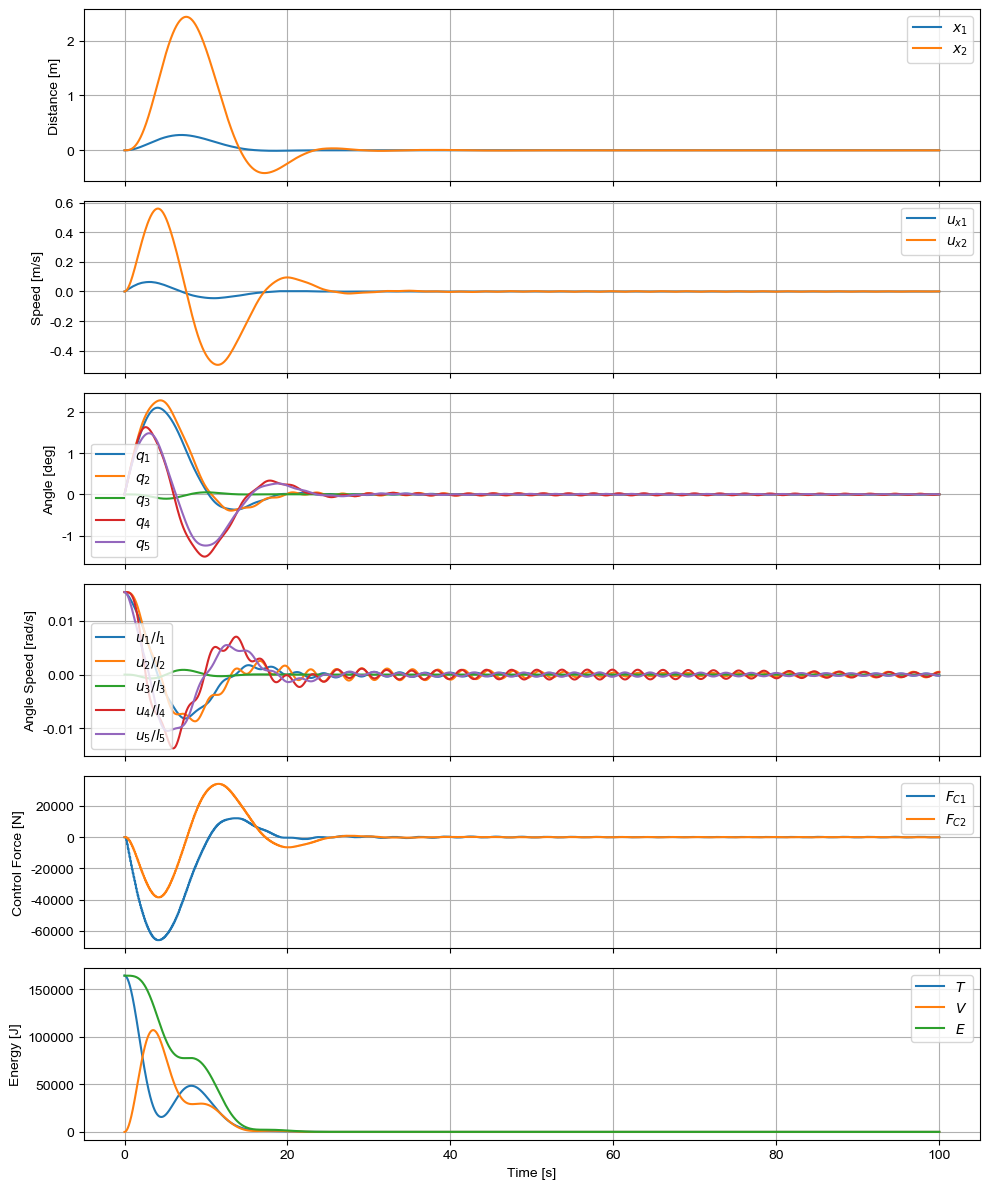

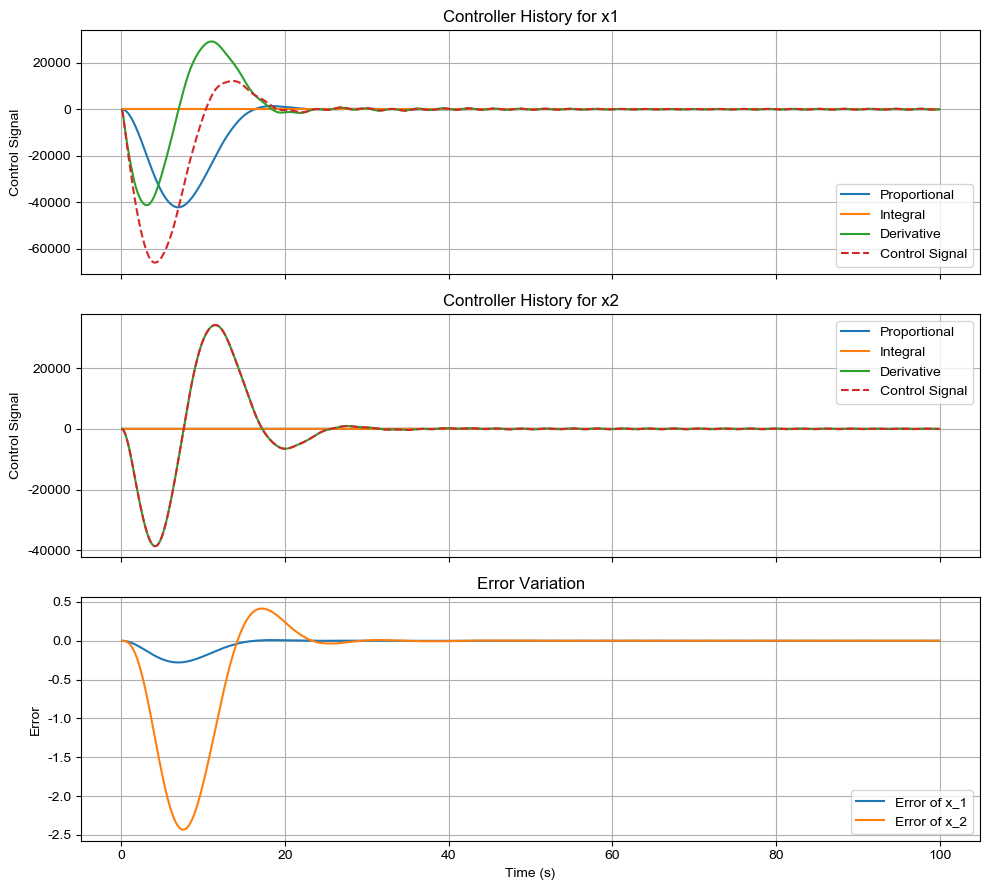

In [24]:
systemfunc.update_PID_params(np.power(10,best_params_woa))
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
systemfunc.control_strategy.plot_history_all()

In [ ]:
systemfunc.update_PID_params(best_params_gwo)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
systemfunc.control_strategy.plot_history_all()

In [ ]:

systemfunc.update_PID_params(new_PID)
systemfunc.run()
print(systemfunc.getOptimizedResult(objective="ITAE"))
systemfunc.plot_results_control_all()
# tool.compare_models_dynamic(systemfunc.ts_dae,[systemfunc.xs_dae[:,:2],],['My',],add_itae=True,itae_starts=x0_CDPD[:2],itae_targets=target,desired_settling_time=100)
systemfunc.control_strategy.plot_history_all()

In [25]:
pos_p_0 = compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],x0_CDPD[2], x0_CDPD[3], x0_CDPD[4])
target_p = pos_p_0[0]
value = ITAE_calc(target_p, systemfunc.params, systemfunc.ts_dae, systemfunc.xs_dae)
print("ITAEp:", value)
ITAEc1 = ITAE_calc1(0, systemfunc.ts_dae, systemfunc.xs_dae)
ITAEc2 = ITAE_calc2(x0_CDPD[1], systemfunc.ts_dae, systemfunc.xs_dae)
print("ITAEc1:", ITAEc1)
print("ITAEc2:", ITAEc2)
overshootc1 = max(systemfunc.xs_dae[:,0]-systemfunc.xs_dae[0,0]) 
print("overshootc1:", overshootc1)
overshootc2 = max(systemfunc.xs_dae[:,1]-systemfunc.xs_dae[0,1]) 
print("overshootc2:", overshootc2)
overshootp = max(np.array([compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],theta1, theta2, theta3)[0] for theta1, theta2, theta3 in zip(systemfunc.xs_dae[:, 2], systemfunc.xs_dae[:, 3], systemfunc.xs_dae[:, 4])])+ systemfunc.xs_dae[:,0]) - pos_p_0[0]
print("overshootp:", overshootp)
# settling_time = systemfunc.control_strategy.compute_settling_time(target, systemfunc.ts_dae, systemfunc.xs_dae)
# print("settling_time:", settling_time)

ITAEp: 118.68696463938515
ITAEc1: 18.789821720025166
ITAEc2: 186.1939454453077
overshootc1: 0.2792185915932066
overshootc2: 2.4332197216309126
overshootp: 2.6458188477586546


In [21]:
def compute_settling_time(target, time, states, tolerance=0.01):
    """
    计算信号稳定到目标值附近的时间。

    参数:
    target: 目标值。
    time: 时间序列，NumPy 数组。
    states: 状态序列，NumPy 数组。
    tolerance: 稳定容差范围。

    返回值:
    稳定时间，如果信号未稳定则返回 inf。
    """
    # 计算信号与目标值的差的绝对值
    abs_diff = np.abs(states - target)

    # 找到信号首次进入容差范围的时间点
    settled = np.where(abs_diff <= tolerance)[0]

    # 如果信号从未进入容差范围，则返回 inf
    if settled.size == 0:
        return float('inf')

    # 找到信号最后一次离开容差范围的时间点
    last_excursion = 0
    for i in range(settled[0], len(states)):
        if abs_diff[i] > tolerance:
            last_excursion = i
    
    # 稳定时间为最后一次离开容差范围后的第一个进入容差范围的时间
    settling_index = np.where(abs_diff[last_excursion:] <= tolerance)[0]
    
    if settling_index.size == 0:
        return float('inf')
    
    settling_time = time[settling_index[0] + last_excursion]
    return settling_time


In [26]:
settling_time_c1 = compute_settling_time(systemfunc.xs_dae[0,0], systemfunc.ts_dae, systemfunc.xs_dae[:,0])
settling_time_c2 = compute_settling_time(systemfunc.xs_dae[0,1], systemfunc.ts_dae, systemfunc.xs_dae[:,1])
settling_time_p = compute_settling_time(target_p, systemfunc.ts_dae, np.array([compute_Pp(p_vals_CDPD[5], p_vals_CDPD[6], p_vals_CDPD[0], p_vals_CDPD[1],theta1, theta2, theta3)[0] for theta1, theta2, theta3 in zip(systemfunc.xs_dae[:, 2], systemfunc.xs_dae[:, 3], systemfunc.xs_dae[:, 4])])+ systemfunc.xs_dae[:,0])

print("settling time c1:", settling_time_c1)
print("settling time c2:", settling_time_c2)
print("settling time p:", settling_time_p)

settling time c1: 15.471547154715472
settling time c2: 31.593159315931594
settling time p: 29.042904290429043


In [ ]:
compare_trolley_and_payload_positions(systemfunc)

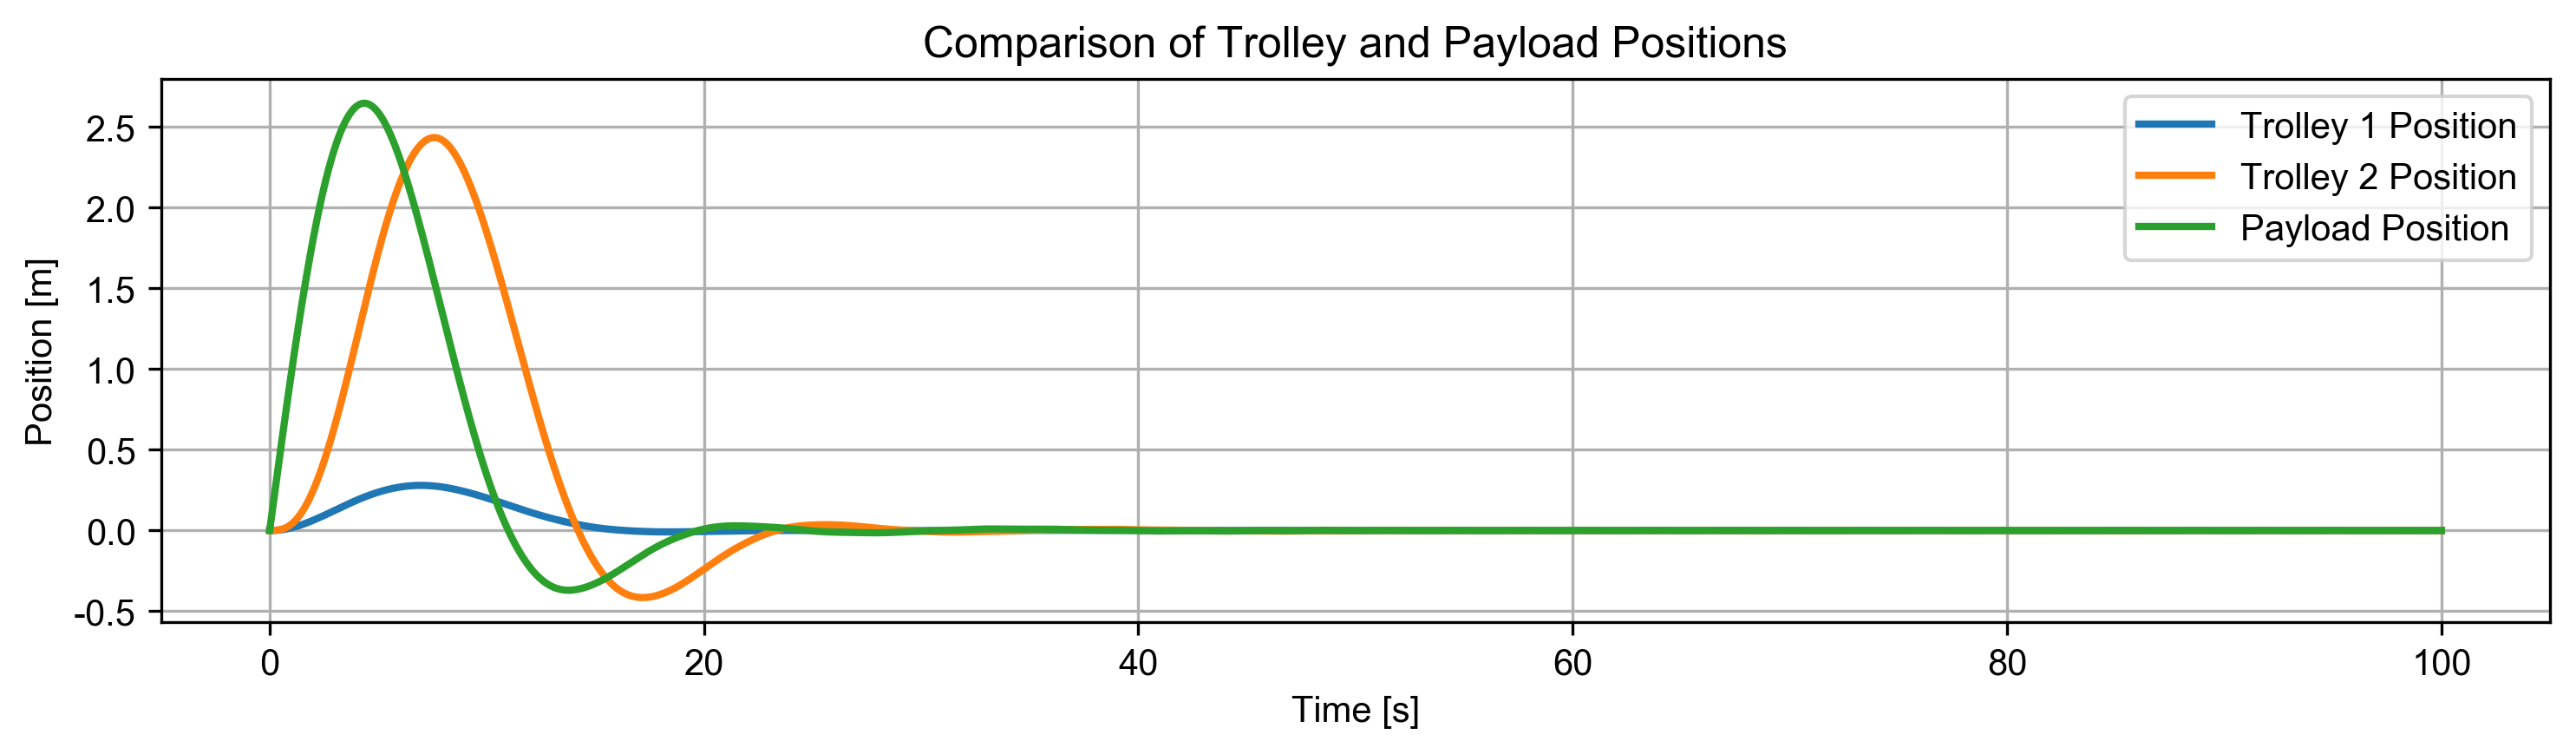

In [27]:
compare_trolley_and_payload_positions_absolute(systemfunc)

ITAEp: 118.65967266855031
ITAEc1: 185.94492072056502
ITAEc2: 18.72660353913525
overshootc1: 2.43093854014611
overshootc2: 0.27907420452851994
overshootp: 2.64544148433135
settling time c1: 31.553155315531555
settling time c2: 15.451545154515452
settling time p: 29.032903290329035

ITAEp: 118.68696463938515
ITAEc1: 18.789821720025166
ITAEc2: 186.1939454453077
overshootc1: 0.2792185915932066
overshootc2: 2.4332197216309126
overshootp: 2.6458188477586546
settling time c1: 15.471547154715472
settling time c2: 31.593159315931594
settling time p: 29.042904290429043